# Lab 3: Extending Logistic Regression

#### *Harrison Noble & Henry Lambson*

## 1. Preparation & Overview

### 1.1 Business Understanding

In this lab we will be using the same wine quality dataset [Ref 1] we used in Lab 1 [Ref 2]. To jog your memory, the wine quality dataset contains 1599 red wine samples and 4898 white wine samples, with 6497 samples in total. There are 12 unique features including the quality value. Each feature is aside from the quality is numerical, with the quality being categorical.

The task for this lab is to create custom logistic regression classifiers and optimization techniques for predicting the quality of both red and white wines based on their physical/chemical attributes. The use-case for a classifier of this nature would be to create an initial screening process for new wines to help wine tasters filter out high quality wines. This would allow wine testers to only test high quality wines that made it through our filter in order to save time and resources that would have been spent on lower quality wines not fit for market. __To create an effective wine quality classifier which could eventually be used as a filtering software, we would like to have a prediction accuracy of 90% or higher that minimizes false positives. Minimizing false positives is ideal for this task so that lower quality wines are more likely to get screened out and only high quality wines make it through. This would lead wine testers/tasters to have a higher level of trust in our algorithm.__ 

__The model created from this dataset would mostly used for offline analysis.__ Because wine testers/tasters do not necessarily need to know the predicted quality of the wine that is produced instantly, this model can be used for offline analysis. One potential application of the model would be doing a weekly analysis of all wines submitted during that week. In this case, wine testers/tasters would gain insights on the high quality wines to potentially test further. 

One change we are making for this lab is keeping the white and red wine datasets seperate. Based on our analysis from Lab 1, we found that some attribute values that make white wine good would make red wine worse and vice versa. Therefore, we will train and test our regression models on each dataset seperately to see if the model works better on one or the other (or both!)

### 1.2 Defining and Preparing Data

In [1]:
import pandas as pd
import numpy as np

#This code chunk was taken from our Lab 1 assignment and edited for this lab.
# load red and white wine datasets into pandas
df_red = pd.read_csv('./winequality-red.csv', sep=';')
df_white = pd.read_csv('./winequality-white.csv', sep=';')

#print number of rows in each df to confirm all data is loaded in
print('Length of red wine dataset:', df_red.shape[0])
print('Length of white wine dataset:', df_white.shape[0])

df_red.head()

Length of red wine dataset: 1599
Length of white wine dataset: 4898


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [2]:
df_white.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Here we are just double checking the data was loaded into the dataframes correctly. One thing we are doing different in this lab is keeping the white and red wines separate. This was stated in section 1.1 but we just wanted to clarify. 

In [3]:
from scipy import stats

to_use = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
          'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
          'pH', 'sulphates', 'alcohol']

#remove outliers with absolute value z-scores 3 or higher
df_red = df_red[(np.abs(stats.zscore(df_red[to_use])) < 3).all(axis=1)]
df_white = df_white[(np.abs(stats.zscore(df_white[to_use])) < 3).all(axis=1)]

print('Length of red wine dataset:', df_red.shape[0])
print('Length of white wine dataset:', df_white.shape[0])

df_red.describe()

Length of red wine dataset: 1458
Length of white wine dataset: 4502


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000
mean,8.312551,0.524050,0.265281,2.388717,0.081531,15.089849,43.660494,0.996718,3.316152,0.642414,10.417798,5.646776
std,1.647635,0.169451,0.191271,0.865307,0.021218,9.317669,29.414615,0.001718,0.141052,0.129753,1.021649,0.801119
min,5.000000,0.120000,0.000000,1.200000,0.038000,1.000000,6.000000,0.991500,2.880000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,21.000000,0.995600,3.220000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,36.000000,0.996700,3.315000,0.620000,10.200000,6.000000
75%,9.200000,0.635000,0.420000,2.600000,0.089000,21.000000,58.000000,0.997800,3.400000,0.720000,11.100000,6.000000
max,13.500000,1.040000,0.790000,6.700000,0.226000,47.000000,145.000000,1.002200,3.750000,1.160000,13.600000,8.000000


In [4]:
df_white.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4502.000000,4502.000000,4502.000000,4502.000000,4502.000000,4502.000000,4502.000000,4502.000000,4502.000000,4502.000000,4502.000000,4502.000000
mean,6.840749,0.271465,0.326513,6.414705,0.043153,34.821302,137.533319,0.993964,3.188256,0.485426,10.540115,5.912261
std,0.786885,0.086082,0.101038,4.954158,0.011724,15.427580,41.323011,0.002908,0.143456,0.105782,1.226173,0.869685
min,4.400000,0.080000,0.000000,0.600000,0.012000,2.000000,19.000000,0.987110,2.790000,0.220000,8.400000,3.000000
25%,6.300000,0.210000,0.270000,1.762500,0.035000,23.000000,108.000000,0.991663,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.310000,5.300000,0.042500,34.000000,133.000000,0.993700,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.380000,9.900000,0.050000,45.000000,166.000000,0.996100,3.280000,0.540000,11.400000,6.000000
max,9.300000,0.580000,0.690000,20.800000,0.110000,86.000000,260.000000,1.001960,3.640000,0.830000,14.200000,9.000000


As we can see, our dataset has no outlier values after removing values with an absolute value z-score greater than or equal to 3. In total, there are now 1458 instances in the red wine dataset and 4502 instances in the white wine dataset. We also know that there are no missing values in either of these datasets from our analysis in Lab 1. We can now remove the quality and store it in a variable called "y" for each respective wine color. This process is shown below:

In [5]:
#extract prediction task (quality) from datasets and then remove
y_red = df_red['quality']
X_red = df_red.drop(columns='quality')
y_white = df_white['quality']
X_white = df_white.drop(columns='quality')

In [6]:
#data description dataframe, used in Lab 1
description_df = pd.DataFrame()

#df_white could also be used here since they have the same attributes
description_df['Attributes'] = df_red.columns

#Description of each attribute
description_df['Description'] = ['grams of tartaric acid per liter', 
                                 'grams of acetic acid per liter',
                                 'grams of citric acid per liter',
                                 'grams of sugar per liter remaining after fermentation stops',
                                 'grams of sodium chloride (salt) per liter',
                                 'milligrams of free form sulfur dioxide per liter',
                                 'milligrams of free form and bound forms of sulfur dioxide per liter',
                                 'density of the wine (grams per cubic centimeter)',
                                 'the pH value of the wine',
                                 'grams of potassium sulphate per liter',
                                 'percent of alcohol by volume',
                                 'median score given by wine tasters (prediction task)']

description_df['Scales'] = ['ratio', 'ratio', 'ratio', 'ratio', 
                            'ratio', 'ratio', 'ratio', 'ratio', 
                            'interval', 'ratio', 'ratio', 'ordinal']

description_df['Discrete\Continuous'] = ['Continuous', 'Continuous', 'Continuous',
                                        'Continuous', 'Continuous', 'Continuous',
                                        'Continuous', 'Continuous', 'Continuous',
                                        'Continuous', 'Continuous', 'Discrete']

#this display option found at: 
#https://stackoverflow.com/questions/25351968/how-to-display-full-non-truncated-dataframe-information-in-html-when-convertin
pd.set_option('display.max_colwidth', None)
description_df

,Attributes,Description,Scales,Discrete\Continuous
0,fixed acidity,grams of tartaric acid per liter,ratio,Continuous
1,volatile acidity,grams of acetic acid per liter,ratio,Continuous
2,citric acid,grams of citric acid per liter,ratio,Continuous
3,residual sugar,grams of sugar per liter remaining after fermentation stops,ratio,Continuous
4,chlorides,grams of sodium chloride (salt) per liter,ratio,Continuous
5,free sulfur dioxide,milligrams of free form sulfur dioxide per liter,ratio,Continuous
6,total sulfur dioxide,milligrams of free form and bound forms of sulfur dioxide per liter,ratio,Continuous
7,density,density of the wine (grams per cubic centimeter),ratio,Continuous
8,pH,the pH value of the wine,interval,Continuous
9,sulphates,grams of potassium sulphate per liter,ratio,Continuous


__Note:__ this table/code was taken from our lab 1 assignment and slightly edited for our needs in this lab. 

The above table gives us a description of each feature, data type (scales), and whether it is discrete or continuous. It should be noted that the "quality" attribute is not actually in the "X_red" or "X_white", but we included it for clarity. This is the final dataset we will be using for our regression tasks. Both white and red wine datasets contain these attributes.

### 1.3 Split Data Into Training & Testing Sets (80/20 Split)

In [7]:
from sklearn.model_selection import train_test_split as tts

#perform 80/20 split on both datasets
X_train_r, X_test_r, y_train_r, y_test_r = tts(X_red, y_red, test_size=0.2)
X_train_w, X_test_w, y_train_w, y_test_w = tts(X_white, y_white, test_size=0.2)

We believe an 80/20 train-test split is a viable option for our dataset because of the size. We consider our datasets relatively small since our processed red wine dataset only contains 1458 instances and our processed white wine dataset contains 4502 instances. Because of this, we need as much training data as possible with a reasonable amount to test on. If our testing set was too small, we do not think the accuracy score of the model would truly represent the performance of the model. 

Another option to split data is dividing it into training, validation, and testing. Like our previous arguement, we do not think our datasets are large enough to perform this type of split. If we had tens to hundreds of thousands of instances, this type of split would be a possbility. 

## 2. Modeling

### 2.1 Create Custom One Vs. All Logistic Regression Classifier

#### 2.1.1 Create BinaryLogisticRegression Class Using Example From Class

In [8]:
#code taken from 06. Optimization notebook
import numpy as np
from scipy.special import expit

class BinaryLogisticRegression:
    #extend init function by adding regularization term
    def __init__(self, eta, iterations=20, C=0.001, regularization_term='none'):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.reg_term = regularization_term
        # internally we will store the weights as self.w_ to keep with sklearn conventions
        
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained Binary Logistic Regression Object'
        
    ################### private ###################
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term
    
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))
    
    #Implement _get_gradient function in sub classes!
    
    ################### public ###################
    def predict_proba(self,X,add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction
    
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            self.w_ += gradient*self.eta # multiply by learning rate 
            # add bacause maximizing 

#### 2.1.2 Create SteepestDescentBLR Class Using Example From Class

In [9]:
class SteepestDescentBLR(BinaryLogisticRegression):
    
    # steepest descent calculation
    def _get_gradient(self,X,y):
        ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        
        if self.reg_term == 'L2':
            gradient[1:] += -2 * self.w_[1:] * self.C
        if self.reg_term == 'L1':
            gradient[1:] += np.sign(self.w_[1:]) * self.C
        if self.reg_term == 'both':
            gradient[1:] += (np.sign(self.w_[1:]) * self.C) + (-2 * self.w_[1:] * self.C)
        
        #if reg_term is 'none' no need to do anything, just return gradient
        return gradient

#### 2.1.3 Create StochasticGradientDescentBLR Class Using Example From Class

In [10]:
class StochasticGradientDescentBLR(BinaryLogisticRegression):
    
    # stochastic gradient calculation 
    def _get_gradient(self,X,y):
        idx = int(np.random.rand()*len(y)) # grab random instance
        ydiff = y[idx]-self.predict_proba(X[idx],add_bias=False) # get y difference (now scalar)
        gradient = X[idx] * ydiff[:,np.newaxis] # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        
        if self.reg_term == 'L2':
            gradient[1:] += -2 * self.w_[1:] * self.C
        if self.reg_term == 'L1':
            gradient[1:] += np.sign(self.w_[1:]) * self.C
        if self.reg_term == 'both':
            gradient[1:] += (np.sign(self.w_[1:]) * self.C) + (-2 * self.w_[1:] * self.C)
        
        #if reg_term is 'none' no need to do anything, just return gradient
        return gradient

#### 2.1.4 Create NetwtonsMethodBLR Class Using Example From Class (Hessian)

In [11]:
from numpy.linalg import pinv

class NewtonsMethodBLR(BinaryLogisticRegression):
    
    # just overwrite gradient function
    def _get_gradient(self,X,y):
        g = self.predict_proba(X,add_bias=False).ravel() # get sigmoid value for all classes
        hessian = X.T @ np.diag(g*(1-g)) @ X - 2 * self.C # calculate the hessian

        ydiff = y-g # get y difference
        gradient = np.sum(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        gradient = gradient.reshape(self.w_.shape)
        
        if self.reg_term == 'L2':
            gradient[1:] += -2 * self.w_[1:] * self.C
        if self.reg_term == 'L1':
            gradient[1:] += np.sign(self.w_[1:]) * self.C
        if self.reg_term == 'both':
            gradient[1:] += (np.sign(self.w_[1:]) * self.C) + (-2 * self.w_[1:] * self.C)
        
        #if reg_term is 'none' no need to do anything, just return gradient
        return pinv(hessian) @ gradient

#### 2.1.5 Create Multiclass Logistic Regression Class Using Example From Class

In [12]:
class MultiClassLogisticRegression:
    def __init__(self, eta, iterations=20, 
                 C=0.0001, 
                 solver=SteepestDescentBLR,
                 regularization_term='none'): #regularization_term options: 'none', 'L1', 'L2', 'both'
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.solver = solver
        #store regularization term
        self.reg_term = regularization_term
        self.classifiers_ = []
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.sort(np.unique(y)) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = []
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = np.array(y==yval).astype(int) # create a binary problem
            # train the binary classifier for this class
            
            #add regularization term to solver params
            blr = self.solver(eta=self.eta,
                              iterations=self.iters,
                              C=self.C,
                              regularization_term=self.reg_term)
            blr.fit(X,y_binary)

            # add the trained classifier to the list
            self.classifiers_.append(blr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
    def predict_proba(self,X):
        probs = []
        for hblr in self.classifiers_:
            probs.append(hblr.predict_proba(X).reshape((len(X),1))) # get probability for each classifier
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):
        return np.argmax(self.predict_proba(X),axis=1) # take argmax along row

To tackle creating a custom one-versus-all logistic regression classifier with the ability to choose different optimization techniques and custom regularizations, we first began with the code provided in notebook 06. optimization. We used the ```BinaryLogisticRegression``` class as our base class and extended it with the ```StochasticLogisticRegression``` (renamed to ```StochasticGradientDescentBLR```), ```HessianBinaryLogisticRegression``` (renamed to ```NewtonsMethodBLR```), and the ```MultiClassLogisticRegression``` classes. Our ```SteepestDescentBLR``` class uses the ```_get_gradient``` function from the base ```BinaryLogisticRegression``` class. We decided to remove the ```_get_gradient``` function from the base class as it is implemented in the ```SteepestDescentBLR``` class. In each of the ```BinaryLogisticRegression``` child classes, the only additional/changed function is the ```_get_gradient``` function which calculates the gradient based on the given optimization technique. 

In regards to adding the ability to choose different optimization techniques, we stuck with your implementation which allowed the classifier to be passed in via a parameter. To add the ability to change normalization term we added the ```regularization_term``` parameter to the base ```BinaryLogisticRegression``` class and the ```MultiClassLogisticRegression``` class. The value for this parameter can either be "L1", "L2", "both", or "none" which specifies the type of regularization to use. To implement the different regularizations, we added a chain of if statements in each child class's ```_get_gradient``` function. If the regularization term chosen was either "L1", "L2", or "both", the gradient was adjusted according to the regularization. If the regularization term was "none", the gradients were not adjusted and simply returned as is. 

### 2.2 Train Classifier to Acheive Good Generalization Performance

#### 2.2.1 Achieve Good Generalization Performance on Red Wine Dataset

In [47]:
import time
from sklearn.metrics import accuracy_score

solvers = [SteepestDescentBLR, StochasticGradientDescentBLR, NewtonsMethodBLR]
etas = [0.0001, 0.001, 0.01, 0.1, 1]
Cs = [0.0001, 0.001, 0.01, 0.1, 1]
regularization_terms = ['none', 'L1', 'L2', 'both']

#use various parameters to predict red wine dataset
best_acc_r = 0
best_params_r = {}
timing_r = 0
for solver in solvers:
    for eta in etas:
        for c in Cs:
            for reg_term in regularization_terms:
                #time each iteration
                t0 = time.time()
                #create the Multiclass Logistic Regression object, train, and test
                mclr = MultiClassLogisticRegression(eta=eta,
                                                    iterations=50,
                                                    C=c,
                                                    solver=solver,
                                                    regularization_term=reg_term)
                mclr.fit(X_train_r, y_train_r)
                mclr_yhat = mclr.predict(X_test_r)
                t1 = time.time()

                time_ms = (t1 - t0) * 1000
                acc = accuracy_score(y_test_r, mclr_yhat)
                
                if acc > best_acc_r:
                    best_acc_r = acc
                    best_params_r = {'Solver': solver,
                                     'Eta': eta,
                                     'C':c,
                                     'Regularization':reg_term}
                    timing_r = time_ms

print('Best model accuracy for red wine dataset is:', best_acc_r)
print('Best parameters are:', best_params_r)
print('Best model took %.2f ms to fit and predict' % timing_r)

Best model accuracy for red wine dataset is: 0.3801369863013699
Best parameters are: {'Solver': <class '__main__.SteepestDescentBLR'>, 'Eta': 0.1, 'C': 1, 'Regularization': 'L2'}
Best model took 19.00 ms to fit and predict


As we can see, the best model for our red wine dataset has an __accuracy score of ~38% in 19 milliseconds.__ It achieves this score by using the steepest descent optimization, an eta value of 0.1, a C value of 1, and L2 regularization. In addition, this model was run with 50 iterations. Lets see if using these parameters and changing the number of iterations has any effect on the accuracy:

In [48]:
iters = [10, 20, 50, 100, 150, 200, 250, 300, 350, 400]

print('%10s %15s %8s' % ('Iterations', 'Accuracy', 'Time (ms)'))
for i in iters:
    #time each iteration
    t0 = time.time()
    #create the Multiclass Logistic Regression object, train, and test
    mclr = MultiClassLogisticRegression(eta=0.1,
                                        iterations=i,
                                        C=1,
                                        solver=SteepestDescentBLR,
                                        regularization_term='L2')
    mclr.fit(X_train_r, y_train_r)
    mclr_yhat = mclr.predict(X_test_r)
    t1 = time.time()

    time_ms = (t1 - t0) * 1000
    acc = accuracy_score(y_test_r, mclr_yhat)
    
    print('%10d %0.13f %.2f' % (i, acc, time_ms))

Iterations        Accuracy Time (ms)
        10 0.0308219178082 10.01
        20 0.3801369863014 10.00
        50 0.3801369863014 23.02
       100 0.0000000000000 37.95
       150 0.0000000000000 55.00
       200 0.0000000000000 74.00
       250 0.0308219178082 93.00
       300 0.0000000000000 109.00
       350 0.3801369863014 132.04
       400 0.0308219178082 138.98


Using __20, 50 and 350 iterations we were able to acheive the same 38%__, meaning that we are able to cut down the runtime by only using 20 iterations. Doing this would __cut our runtime from 19 ms to 10 ms while still keeping the same 38% accuracy.__

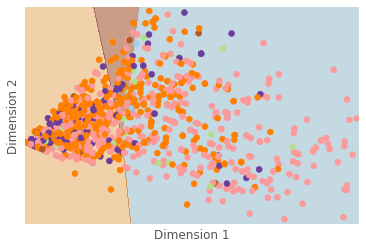

In [14]:
from sklearn.decomposition import PCA

X = X_train_r.copy()

pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

from matplotlib import pyplot as plt
import copy
%matplotlib inline
plt.style.use('ggplot')

#copied from notebook 05. logistic regression
def plot_decision_boundaries(lr,Xin,y,title=''):
    Xb = copy.deepcopy(Xin)
    lr.fit(Xb[:,:2],y) # train only on two features

    h=0.01
    # create a mesh to plot in
    x_min, x_max = Xb[:, 0].min() - 1, Xb[:, 0].max() + 1
    y_min, y_max = Xb[:, 1].min() - 1, Xb[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # get prediction values
    Z = lr.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.5)

    # Plot also the training points
    plt.scatter(Xb[:, 0], Xb[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(title)
    plt.show()
    
mclr = MultiClassLogisticRegression(eta=0.1,
                                    iterations=20,
                                    C=1,
                                    solver=SteepestDescentBLR,
                                    regularization_term='L2')

plot_decision_boundaries(mclr,X_pca,y_train_r)

We tried to visualize the data by reducing the amount of dimesions down to 2 so that we could view the data on a 2D graph. From this visualization we can see multiple different decision bundaries, however, they are not very well placed. This could be due to the reduction of dimensions or the fact that our classifier only gets ~38% accuracy. Additionally, because of the large cluster on the left side of the graph, the classifier seems to have a difficult time differentiating between those instances.   Nevertheless, this gives us a better idea of how the classifier is determining the quality of each red wine.    

#### 2.2.2 Achieve Good Generalization Performance on White Wine Dataset

In [50]:
import time
from sklearn.metrics import accuracy_score

#repeat same process but with white wine dataset
best_acc_w = 0
best_params_w = {}
timing_w = 0

solvers = [SteepestDescentBLR, StochasticGradientDescentBLR, NewtonsMethodBLR]
etas = [0.0001, 0.001, 0.01, 0.1, 1]
Cs = [0.0001, 0.001, 0.01, 0.1, 1]
regularization_terms = ['none', 'L1', 'L2', 'both']

for solver in solvers:
    for eta in etas:
        for c in Cs:
            for reg_term in regularization_terms:
                #time each iteration
                t0 = time.time()
                #create the Multiclass Logistic Regression object, train, and test
                mclr = MultiClassLogisticRegression(eta=1,
                                                    iterations=50,
                                                    C=c,
                                                    solver=solver,
                                                    regularization_term=reg_term)
                mclr.fit(X_train_w, y_train_w)
                mclr_yhat = mclr.predict(X_test_w)
                t1 = time.time()

                time_ms = (t1 - t0) * 1000
                acc = accuracy_score(y_test_w, mclr_yhat)

                if acc > best_acc_w:
                    best_acc_w = acc
                    best_params_w = {'Solver': solver,
                                     'Eta': eta,
                                     'C':c,
                                     'Regularization':reg_term}
                    timing_w = time_ms

print('Best model accuracy for white wine dataset is:', best_acc_w)
print('Best parameters are:', best_params_w)
print('Best model took %.2f ms to fit and predict' % timing_w)

Best model accuracy for white wine dataset is: 0.4672586015538291
Best parameters are: {'Solver': <class '__main__.StochasticGradientDescentBLR'>, 'Eta': 0.1, 'C': 0.1, 'Regularization': 'both'}
Best model took 8.00 ms to fit and predict


As we can see, the best model for our white wine dataset has an __accuracy score of around ~47% in 8 milliseconds.__ It achieves this score by using the stochastic gradient descent optimazation, an eta value of 0.1, a C value of 0.1, and both L1 and L2 regularizations. This model was run with 50 iterations. Lets see if using these parameters and changing the number of iterations has any effect on the accuracy:

In [52]:
iters = [10, 20, 50, 100, 150, 200, 250, 300, 350, 400]

print('%10s %15s %8s' % ('Iterations', 'Accuracy', 'Time (ms)'))
for i in iters:
    #time each iteration
    t0 = time.time()
    #create the Multiclass Logistic Regression object, train, and test
    mclr = MultiClassLogisticRegression(eta=0.1,
                                        iterations=i,
                                        C=0.1,
                                        solver=StochasticGradientDescentBLR,
                                        regularization_term='both')
    mclr.fit(X_train_w, y_train_w)
    mclr_yhat = mclr.predict(X_test_w)
    t1 = time.time()

    time_ms = (t1 - t0) * 1000
    acc = accuracy_score(y_test_w, mclr_yhat)
    
    print('%10d %0.13f %.2f' % (i, acc, time_ms))

Iterations        Accuracy Time (ms)
        10 0.0011098779134 5.04
        20 0.0000000000000 5.00
        50 0.0000000000000 10.05
       100 0.0011098779134 19.00
       150 0.4661487236404 23.00
       200 0.0000000000000 36.00
       250 0.3473917869034 41.00
       300 0.4639289678135 47.01
       350 0.0000000000000 51.99
       400 0.0000000000000 62.00


We were able to reproduce the __~47% value by using 150 iterations which took 23 ms__, which is much longer than our initial time. Running it at 300 iterations also produced a similar percentage. We needed to run through this block a few times in order to acheive these percentages __because stochastic picks a random instance in each gradient calculation__. We think we got fairly lucky on the run throughs above because we are seeing mostly poor accuracies using stochastic gradient descent.          

In [ ]:
from sklearn.decomposition import PCA

X = X_train_w.copy()

pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

from matplotlib import pyplot as plt
import copy
%matplotlib inline
plt.style.use('ggplot')

    
mclr = MultiClassLogisticRegression(eta=0.1,
                                    iterations=20,
                                    C=0.1,
                                    solver=StochasticGradientDescentBLR,
                                    regularization_term='both')

plot_decision_boundaries(mclr,X_pca,y_train_w)

We tried running this block on both of our computers, but the kernel or our actual computers kept crashing, so we are just not going to run it. We are assuming that the results of visualizing the decision boundaries would be similar to the red dataset in that there are distinct boundaries, but they would not be well placed.   

#### 2.2.3 Analysis of Parameter Selection and Data Snooping


We believe our method of electing parameters was justified , as we had 4 nested for loops that were iterating through each combination of the parameters. Doing this, we were able to identify which the model with the best accuracy score so that we could test further using its parameters. We believe that we had data snooping in doing this because we were exhaustivly searching for the best parameters given the dataset. Both datasets had models that resulted in a prediction of 0%, and only a few models with predection rates that were even relatively high. This insinuates that the high prediction rate models could have occurred by chance, meaning that there was data snooping. Based off of this, if we were to give this model data it has never seen before, we are not confident that it will be able to predict well.       

### 2.3 Comparing Our Optimization Performance to The Godly Scikit-Learn Optimization

#### 2.3.1 Comparing Scikit-Learn Optimization on Red Wine Dataset

In [54]:
from sklearn.linear_model import LogisticRegression

#test sklearn on red wine dataset
t0 = time.time()
skl_logreg = LogisticRegression(solver='liblinear')

skl_logreg.fit(X_train_r, y_train_r)
skl_yhat = skl_logreg.predict(X_test_r)
t1 = time.time()

print('SciKit-Learn accuracy score on red wine test dataset:', 
      accuracy_score(y_test_r, skl_yhat))
print('Total execution time: %.2f milliseconds' % ((t1-t0) * 1000))

SciKit-Learn accuracy score on red wine test dataset: 0.6095890410958904
Total execution time: 40.13 milliseconds


#### 2.3.2 Comparing Scikit-Learn Optimization on White Wine Dataset

In [55]:
#test sklearn on white wine dataset
t0 = time.time()
skl_logreg = LogisticRegression(solver='liblinear')

skl_logreg.fit(X_train_w, y_train_w)
skl_yhat = skl_logreg.predict(X_test_w)
t1 = time.time()

print('SciKit-Learn accuracy score on white wine test dataset:', 
      accuracy_score(y_test_w, skl_yhat))
print('Total execution time: %.2f milliseconds' % ((t1-t0) * 1000))

SciKit-Learn accuracy score on white wine test dataset: 0.5338512763596004
Total execution time: 152.18 milliseconds


## 3. Deployment


For the red wine dataset, we can see that the Scikit-Learn optimization is vastly superior to our implementation in regards to accuracy, acheiving an accuracy of ~61% while ours only got 38%. However, our implementation is much faster than the Scikit-Learn implementation, only taking 10 ms for ours compared to 40 ms for Scikit-Learn. Despite this, we believe that the Scikit-Learn implementation is much better suited for the red wine dataset because we are valuing accuracy over speed. Like we said in the Business Understanding, speed is not too much of an issue for us because we are planning to use this for offline analysis.

For the white wine dataset, the Scikit-Learn optimization acheived a ~53% accuracy while taking 152 ms. Our implementation acheived ~47% accuracy in only 8 ms. Even though these are much closer to each other in terms of accuracy, we believe that our 47% accuracy is based off of a lucky run using stochastic gradient descent. Because of this, we are still going to pick the Scikit-Learn implementation over ours despite the huge difference in speed because it will be much more consistent in terms of accuracy. 

Despite what we just said, we would not reccomend either Scikit-Learn or our implementations for a predection task of this nature. As we said in our business understanding, we want to acheive an accuracy of 90% or higher, and both of these options perform significantly worse than our baseline. We believe that this task is better suited for a neural network and that it will have much better results. The only way to test this is through future labs.   

## 4. Exceptional Work: Random Forest Regression

For our exceptional work, we decided to implement random forest regression. We found this regression technique on page 347-348 in *Python Machine Learning*, by Sebastian Raschka. We wanted to see if this implementation provided any better prediction with our dataset. 

In [42]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import accuracy_score
import time

tree_regressor = DecisionTreeRegressor()

t0 = time.time()
tree_regressor.fit(X_train_r, y_train_r)
yhat_r = tree_regressor.predict(X_test_r)
t1 = time.time()

t_ms = (t1 - t0) * 1000

print('Accuracy score on red wine for Decision Tree Regressor:', 
      accuracy_score(y_test_r, yhat_r))
print('Fitting and predicting took %.2f ms for red wine' % t_ms)
print('Decision tree depth:', tree_regressor.get_depth(),
      'and number of leaves:', tree_regressor.get_n_leaves())
print('\n')

t0 = time.time()
tree_regressor.fit(X_train_w, y_train_w)
yhat_w = tree_regressor.predict(X_test_w)
t1 = time.time()

t_ms = (t1 - t0) * 1000

print('Accuracy score on white wine for Decision Tree Regressor:', 
      accuracy_score(y_test_w, yhat_w))
print('Fitting and predicting took %.2f ms for white wine' % t_ms)
print('Decision tree depth:', tree_regressor.get_depth(),
      'and number of leaves:', tree_regressor.get_n_leaves())

Accuracy score on red wine for Decision Tree Regressor: 0.6472602739726028
Fitting and predicting took 31.40 ms for red wine
Decision tree depth: 18 and number of leaves: 315


Accuracy score on white wine for Decision Tree Regressor: 0.6137624861265261
Fitting and predicting took 79.55 ms for white wine
Decision tree depth: 23 and number of leaves: 1004


Wow! Using this regression technique we achieved better scores compared to the logistic regression also within scikit-learn. We can see that for the red wine dataset, this regression technique took 31 ms (9 ms less than the logistic regression model) and achieved an accuracy score of nearly 65% (almost 4% better than logistic regression). 

For the white wine dataset, we see even better results. The DecisionTreeRegressor model only took 80ms to fit and predict compared to the LogisticRegression model which took 150ms to fit in predict. The decision tree regressor cut the fitting and predicting time basically in half! Additionally, the decision tree regressor was about 8% more accurate compared to the logistic regression model. 

From our understanding, decision trees are essentially huge chain of nested if-else statements. Each if-else block checks the value of certian features and continues down the chain (branches) of statements. Once an instance reaches a leaf the decision tree will know what to predict for the instance. In our case, the red wine decision tree regressor had a depth of 18 and 315 leaves and the white wine decision tree regressor had a depth of 23 and 1004 leaves. We attempted to plot the red wine decision tree but it was far too big and we could not find a better way to visualize it other than text. 

Even though this technique performed better than all the other techniques analyzed in this lab, it still falls much too short of our baseline prediction accuracy of 90%. 

## References

[1] UCI Machine Learning Repository. Wine Quality Dataset. https://archive.ics.uci.edu/ml/datasets/Wine+Quality

[2] Lab 1: Exploring Table Data

[3] *Python Machine Learning*, by Sebastian Raschka